Sabermetrics Final Project Plan - Situational Pitching Behavior
    - Write a function that takes a playerID, Score, Runners on as an argument and sets it to the player ID being searched
    - Write a query to look up that playerID in certain situation
    - Compile certain statistics such as most likely pitch and pitch location
    - Present statitics gathered with plots/text

In [74]:
from pybaseball import statcast
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# query - very large, only run if no exisiting data csv
data = statcast(start_dt='2017-04-01', end_dt='2017-10-01')

This is a large query, it may take a moment to complete
Completed sub-query from 2017-04-01 to 2017-04-06
Completed sub-query from 2017-04-07 to 2017-04-12
Completed sub-query from 2017-04-13 to 2017-04-18
Completed sub-query from 2017-04-19 to 2017-04-24
Completed sub-query from 2017-04-25 to 2017-04-30
Completed sub-query from 2017-05-01 to 2017-05-06
Completed sub-query from 2017-05-07 to 2017-05-12
Completed sub-query from 2017-05-13 to 2017-05-18
Completed sub-query from 2017-05-19 to 2017-05-24
Completed sub-query from 2017-05-25 to 2017-05-30
Completed sub-query from 2017-05-31 to 2017-06-05
Completed sub-query from 2017-06-06 to 2017-06-11
Completed sub-query from 2017-06-12 to 2017-06-17
Completed sub-query from 2017-06-18 to 2017-06-23
Completed sub-query from 2017-06-24 to 2017-06-29
Completed sub-query from 2017-06-30 to 2017-07-05
Completed sub-query from 2017-07-06 to 2017-07-11
Completed sub-query from 2017-07-12 to 2017-07-17
Completed sub-query from 2017-07-18 to 2017-

In [62]:
# read query data to a csv is necessary, otherwise grab from csv
# data.to_csv("final_pitching_data.csv")
data = pd.read_csv("final_pitching_data.csv") 

C:\Users\Sam\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
def lookup(playerID, strikes, balls, on_1b, on_2b, on_3b):
    # runner on first
    if on_1b and not on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].notnull()) & (data['on_2b'].isnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on second
    elif not on_1b and on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].isnull()) & (data['on_2b'].notnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on third
    elif not on_1b and not on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].isnull()) & (data['on_2b'].isnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
   
    # runner on first and second
    elif on_1b and on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].notnull()) & (data['on_2b'].notnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on first and third 
    elif on_1b and not on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].notnull()) & (data['on_2b'].isnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on second and third
    elif not on_1b and on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].isnull()) & (data['on_2b'].notnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    
    # runner on first, second, third
    elif on_1b and  on_2b and on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].notnull()) & (data['on_2b'].notnull()) & (data['on_3b'].notnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    # no runners on
    elif not on_1b and not on_2b and not on_3b:
        situation_data = data.loc[((data['pitcher'] == playerID) & (data['strikes'] == strikes) & (data['balls'] == balls)
                                   & (data['on_1b'].isnull()) & (data['on_2b'].isnull()) & (data['on_3b'].isnull())), 
                                    ['pitcher', 'at_bat_number', 'pitch_type','type', 'plate_x', 'plate_z', 'strikes', 'balls', 'on_1b', 'on_2b', 'on_3b']]
    return situation_data

In [212]:
def isolate_data(sit_data):
    # compare the types of pitches pitchers throw at home vs away
    pitches = {}
    descriptions = {}
    pitch_type_counts = sit_data.groupby(['pitch_type']).count().reset_index()    
    total_pitches = pitch_type_counts['pitcher'].sum()

    #add the pitch types and their frequency to a dictionary 
    for index, row in pitch_type_counts.iterrows():
        pitches[row['pitch_type']] = row['pitcher']
        
    # get mean location data
    x_location_mean = sit_data['plate_x'].mean()
    z_location_mean = sit_data['plate_z'].mean()
 
    # get number of strikes/balls/hits thrown in situation
    pitch_description_counts = sit_data.groupby(['type']).count().reset_index()
    for index, row in pitch_description_counts.iterrows():
        descriptions[row['type']] = row['pitcher']
    
    return total_pitches, pitches, descriptions, x_location_mean, z_location_mean

In [213]:
def process_data(isol_data):
    # if there is data for this situation, isolate the data points we are looking for
    tot_pitches, pitch_counts, pitch_descriptions, x_loc_mean, z_loc_mean = isolate_data(isol_data)
    # get the most likely pitch to be thrown
    max_pitch = 0
    # dictonary to store the types of pitches they could throw and the statistical frequency that they will
    pitch_freqs = {}
    for key, value in pitch_counts.items():
        pitch_freqs[key] = value/tot_pitches

    # dictionary to store outcome percentages
    outcome_freqs = {}
    for key, value in pitch_descriptions.items():
        outcome_freqs[key] = value/tot_pitches

    return tot_pitches, pitch_freqs, outcome_freqs, x_loc_mean, z_loc_mean
       

In [223]:
def display_results(p_data):
    print("There are", p_data[0], "data points for this pitcher in this situation")
    
    print("The odds that the pitcher will throw a specific pitch in this situation are the following \n", p_data[1])
    plt.bar(range(len(p_data[1])), list(p_data[1].values()), align='center')
    plt.xticks(range(len(p_data[1])), list(p_data[1].keys()))
    plt.title("Pitch Frequencies")
    plt.xlabel("Pitch Type")
    plt.ylabel("Frequency")
    plt.show()
    
    print("The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following \n", p_data[2])
    plt.bar(range(len(p_data[2])), list(p_data[2].values()), align='center')
    plt.xticks(range(len(p_data[2])), list(p_data[2].keys()))
    plt.title("Outcome Frequencies")
    plt.xlabel("Result of Pitch")
    plt.ylabel("Frequency")
    plt.show()
    
    # get the average location of where the pitch will be thrown based off the mean x (horizontal) location and mean z (vertical) location
    print("The average position of the ball over the plate, from the catcher's perspective,\n (0,0 being directly over the center of the plate in the middle of the batters box) \n in this situation for this pitcher is \n(", p_data[3], ",", p_data[4],")")
    plt.plot(p_data[3], p_data[4], 'ro', markersize=15)
    plt.grid(color='black', linestyle='-', linewidth=.8)
    plt.axis([-5, 5, -5, 5])
    plt.xlabel("Horiztional Position")
    plt.ylabel("Vertical Position")
    plt.title("Average Pitch Location")
    plt.show()

In [224]:
def main(playerID, strikes, balls, on_1b, on_2b, on_3b):
    # call the lookup function with the specified siutational parameters
    SPB_data = lookup(playerID, strikes, balls, on_1b, on_2b, on_3b)
    # if the length of the returned data frame is 0 there is no data for that specific situation
    if (len(SPB_data) == 0):
        print("No data available for described situation")
        return
    
    # process the isolated data
    processed_data = process_data(SPB_data)

    # display results
    display_results(processed_data)

There are 29 data points for this pitcher in this situation
The odds that the pitcher will throw a specific pitch in this situation are the following 
 {'FC': 0.2413793103448276, 'FF': 0.3103448275862069, 'FT': 0.1724137931034483, 'SL': 0.27586206896551724}


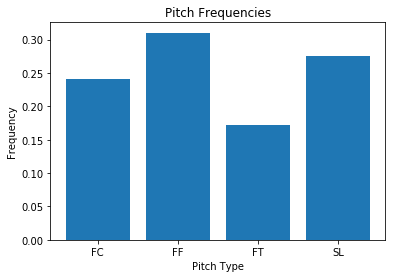

The odds of a specific outcome (B - Ball, S - Strike, X - Ball In Play) are the following 
 {'B': 0.20689655172413793, 'S': 0.4482758620689655, 'X': 0.3448275862068966}


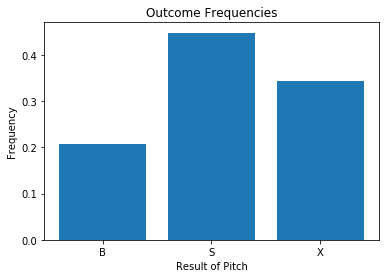

The average position of the ball over the plate, from the catcher's perspective,
 (0,0 being directly over the center of the plate in the middle of the batters box) 
 in this situation for this pitcher is 
( 0.25056896551724134 , 2.3588275862068966 )


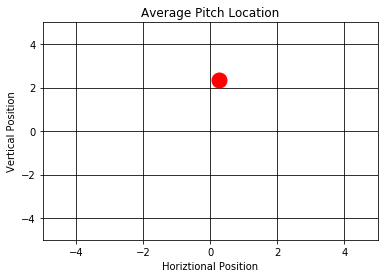

In [225]:
main(532077.0, 2, 3, False, False, False)